# Analysis of Monthly Mean Historical Meteorologic Variables from LOCA and BCSD

This notebook analyzes meteorologic variables from the historical scenario (1950-2005) from the LOCA and BCSD datasets. Each dataset is compared to its respective gridded observations used for training -- Livneh observations for LOCA and Maurer observations for BCSD.

Variables include:
- Precipitation
- Temperature

In [11]:
from loca import print_date
print_date()

Last executed: 2019-03-22 12:51:25.385368 by jvano on r6i7n3


# Imports and Options

In [12]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

import os
import matplotlib.pyplot as plt

import xarray as xr

from loca.data_catalog import load_monthly_historical_met_datasets, load_daily_livneh_meteorology, resample_monthly_data
from loca.utils import calc_change

# models = ['ACCESS1-0', 'CanESM2', 'CNRM-CM5', 'MIROC5', 'MRI-CGCM3']
# models = ['CCSM4', 'CNRM-CM5']
# models = ['ACCESS1-0', 'CanESM2', 'CCSM4', 'CNRM-CM5', 'MIROC5', 'MRI-CGCM3']
# models = ['ACCESS1-0', 'CanESM2'] 
models = ['ACCESS1-0', 'CanESM2','MIROC5', 'MRI-CGCM3']

# list of 20, without issues
#models = ['ACCESS1-0', 'CanESM2', 'MIROC5', 'MRI-CGCM3', 'bcc-csm1-1', 'bcc-csm1-1-m', 'CCSM4', 'CESM1-BGC', 'CMCC-CM', 'GISS-E2-R', 'HadGEM2-CC', 'HadGEM2-ES', 'inmcm4', 'IPSL-CM5A-MR', 'MIROC-ESM', 'MIROC-ESM-CHEM', 'MPI-ESM-LR', 'MPI-ESM-MR', 'NorESM1-M', 'GFDL-ESM2G']


met_vars = ['pcp', 't_mean']

#cache is written in script xxx (TODO need to move it to its own script)
read_cache = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
from dask.distributed import Client
# client = Client(scheduler_file='/glade/u/home/jhamman/workdir/scheduler_file.json')
client = Client(scheduler_file=os.path.join(os.environ['HOME'], 'scheduler_file.json'))
client

Client Scheduler: tcp://10.148.10.31:47938 Dashboard: proxy/36866/status,Cluster Workers: 72 Cores: 288 Memory: 360.00 GB


In [9]:
# attempt reading in obs - see next few slides... much better to put it 
DEFAULT_RESOLUTION = '8th'

def load_monthly_obs_met_datasets(resolution=DEFAULT_RESOLUTION,
                                         models=None, **kwargs):
    print('load_monthly_historical_met_datasets', flush=True)

    data['livneh'] = load_monthly_livneh_meteorology(resolution=resolution,
                                                     **kwargs)
    data['maurer'] = load_monthly_maurer_meteorology(resolution=resolution,
                                                     **kwargs)

    return data


In [10]:
#met_obs_data = load_monthly_obs_met_datasets(models=models, autoclose=True, parallel=True)

load_monthly_historical_met_datasets


NameError: name 'load_monthly_livneh_meteorology' is not defined

# Load Data

In [14]:
hist_cmip_met_data = {}
if read_cache:
    print("reading values from cache")
    for key in ['loca', 'bcsd']:
        hist_cmip_met_data[key] = xr.open_mfdataset(
            os.path.join(os.environ['TMPDIR'], f'monthly_cmip_met_hist.{key}_*.nc'),
            concat_dim='gcm', chunks={'time': 72})
    print("finished reading from cache")
    ds = hist_cmip_met_data['loca']
    print(ds['pcp'])
    #TODO once get obs load separate won't have to do work around below
    single = ['ACCESS1-0']
    obs_data = load_monthly_historical_met_datasets(models=single, autoclose=True, parallel=True)
    print("finished reading obs")

else:
    print("reading values from files directly")
    met_data = load_monthly_historical_met_datasets(models=models, autoclose=True, parallel=True)

reading values from cache
finished reading from cache
<xarray.DataArray 'pcp' (gcm: 20, time: 672, lat: 224, lon: 464)>
dask.array<shape=(20, 672, 224, 464), dtype=float64, chunksize=(1, 72, 224, 464)>
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2005-12-01
  * lon      (lon) float64 -124.9 -124.8 -124.7 -124.6 ... -67.31 -67.19 -67.06
  * lat      (lat) float64 25.06 25.19 25.31 25.44 ... 52.56 52.69 52.81 52.94
  * gcm      (gcm) <U14 'ACCESS1-0' 'CCSM4' ... 'bcc-csm1-1' 'inmcm4'
load_monthly_historical_met_datasets
load_monthly_cmip_met_datasets
load_monthly_loca_meteorology
load_daily_loca_meteorology
load_monthly_bcsd_meteorology
load_bcsd_dataset
load_monthly_livneh_meteorology
load_daily_livneh_meteorology
load_monthly_maurer_meteorology
load_daily_maurer_meteorology
finished reading obs


In [15]:
# merging
met_data = {**obs_data, **hist_cmip_met_data}
#list(met_data.keys())
#print(met_data)

In [76]:
#client.restart()

Client Scheduler: tcp://10.148.10.31:47938 Dashboard: proxy/36866/status,Cluster Workers: 72 Cores: 288 Memory: 360.00 GB


In [77]:
#epoch = slice('1970-01-01', '1999-12-30') # Joe's previous
# epoch = slice('1970-01-01', '1999-09-30') # minusfirst3mon
# epoch = slice('1969-10-01', '1999-09-30') # Julie updated to be water year
# epoch = slice('1969-10-01', '1999-12-30') # pluslast3mon, long avg 
# epoch = slice('1970-01-01', '1979-12-30') # decades
# epoch = slice('1970-01-01', '1978-01-01') # doesn't work
# epoch = slice('1979-02-01', '1979-02-15') # edge of where it breaks

epoch = slice('1979-10-01', '1999-09-30') # 20 year avg, using until I figure out what is up with earlier years.

mask = met_data['maurer']['t_mean'].isel(time=0).squeeze().notnull()

epoch_means = dict((k, resample_monthly_data(ds.sel(time=epoch), freq='AS',
                                             chunks={'lat': 100, 'lon': 100}).mean('time').where(mask).persist()) for (k, ds) in met_data.items())
ens_means = dict((k, resample_monthly_data(ds.sel(time=epoch), freq='AS', chunks={'lat': 100, 'lon': 100}).mean('time').mean('gcm').where(mask).persist()) for (k, ds) in hist_cmip_met_data.items())

# for debugging
# epoch_means = {}
# for k, ds in met_data.items():
#     print(k, flush=True)
#     epoch_means[k] = ds.sel(time=epoch).mean('time').where(mask).compute()

In [17]:
#list(met_data.keys())
#ds = met_data['bcsd']
#print(ds['time'])

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://10.148.10.31:37496 remote=tcp://10.148.10.31:47938>


In [18]:
#test = slice('1969-09-01', '1969-12-30')
#test = slice('1999-09-01', '1999-12-30')
#ds = met_data['bcsd']
#ds['pcp'].sel(time=test)

# Plots

For the monthly hydrologic variables, we will make 2 types of plots:

1. Maps of all datasets plotted as actual values (epoch, seasonal, and monthly means)
2. Maps of all datasets with LOCA and BCSD datasets plotted as biases relative to observation based VIC simulations (epoch, seasonal, and monthly means)

In [19]:
kwargs = {'pcp': {'vmin': 0, 'vmax': 2500},
          't_mean': {'vmin': -10, 'vmax': 20},}
units = {'pcp': 'mm', 't_mean': 'C'}

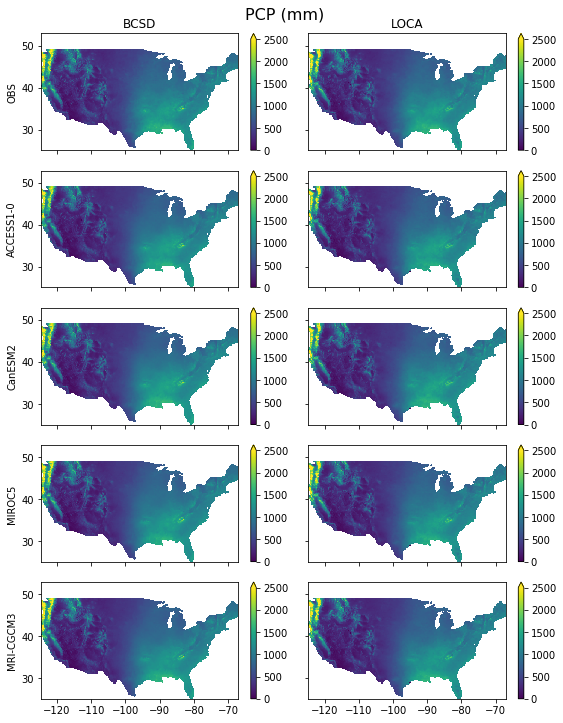

In [23]:
nrows = 1 + len(models)
ncols = 2

for var in met_vars:
    
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, sharex=True, sharey=True, figsize=(4*ncols, 2*nrows))
    
    for col, (title, obs_data, ds_data) in enumerate([('BCSD', epoch_means['maurer'], epoch_means['bcsd']),
                                                      ('LOCA', epoch_means['livneh'], epoch_means['loca'])]):
        
        ax = axes[0, col]
        obs_data[var].plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])
        
        if col == 0:
            ax.set_ylabel('OBS')
        
        ax.set_title(title)
        
        for row, model in enumerate(models, 1):
            ax = axes[row, col]
            ds_data[var].sel(gcm=model).plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])
            
            if col == 0:
                ax.set_ylabel(model)
                
    title = var.upper()
    title += ' (%s)' % units[var]
    unit_str = units[var]
    fig.suptitle(title, fontsize=16, y=1.0)
    fig.tight_layout()     
    fig.savefig(f'/glade/u/home/jvano/workdir/loca_figs/{var}_{unit_str}_monthly_historic_met.png', dpi=300, bbox_inches='tight')

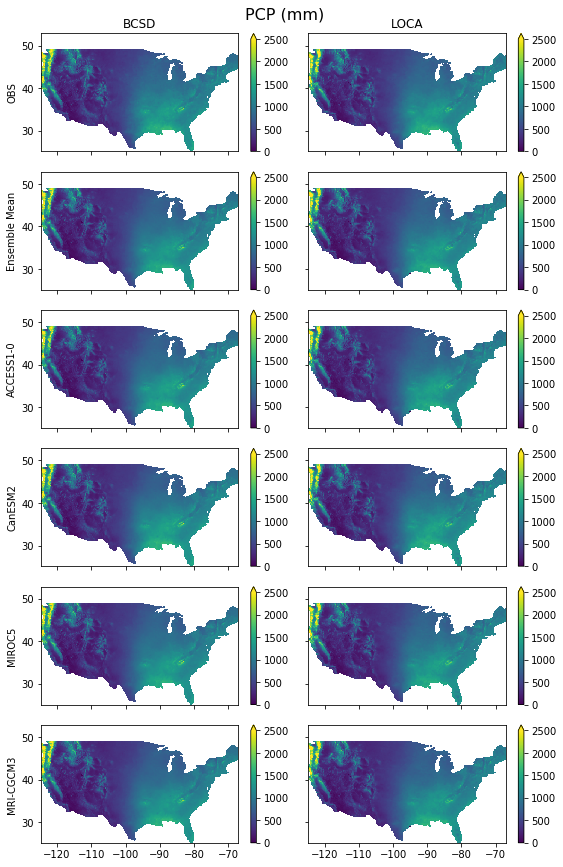

In [22]:
# NEW:  Ensemble added
nrows = 2 + len(models)
ncols = 2

met_vars = ['pcp']
for var in met_vars:
    
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, sharex=True, sharey=True, figsize=(4*ncols, 2*nrows))
    
    for col, (title, obs_data, ensemble, ds_data) in enumerate([('BCSD', epoch_means['maurer'], ens_means['bcsd'], epoch_means['bcsd']),
                                                      ('LOCA', epoch_means['livneh'], ens_means['loca'], epoch_means['loca'])]):
        
        ax = axes[0, col]
        obs_data[var].plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])
        ax.set_title(title)
        
        if col == 0:
            ax.set_ylabel('OBS')
        
        ax = axes[1, col]
        ensemble[var].plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])
        if col == 0:
            ax.set_ylabel('Ensemble Mean')
        
        for row, model in enumerate(models, 2):
            ax = axes[row, col]
            ds_data[var].sel(gcm=model).plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])
            
            if col == 0:
                ax.set_ylabel(model)
                
    title = var.upper()
    title += ' (%s)' % units[var]
    unit_str = units[var]
    fig.suptitle(title, fontsize=16, y=1.0)
    fig.tight_layout()     
    fig.savefig(f'/glade/u/home/jvano/workdir/loca_figs/{var}_{unit_str}_monthly_historic_met_ens_80s-90s.png', dpi=300, bbox_inches='tight')

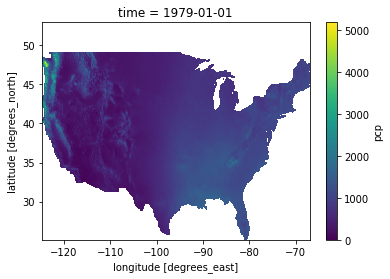

In [72]:
#USEFUL WAY TO MAKE A PLOT
#ens_means['loca']['pcp'].plot()

In [79]:
diff_kws[pct][var]

{'vmin': -100, 'vmax': 100, 'cmap': 'RdBu'}

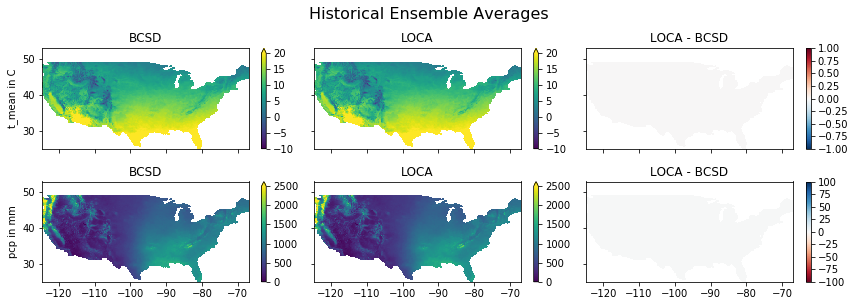

In [86]:
# new fig of just ensemble average of loca, bcsd, diff

met_vars = ['t_mean', 'pcp']

nrows = len(met_vars)
ncols = 3

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, sharex=True, sharey=True, figsize=(4*ncols, 2*nrows))


for row, var in enumerate(met_vars):
        
    for col, (title, ensemble) in enumerate([('BCSD', ens_means['bcsd'],),
                                             ('LOCA', ens_means['bcsd'])]):
        
        ax = axes[row, col]
        ax.set_title(title)
        
        ensemble[var].plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])
        if col == 0:
            ax.set_ylabel(f'{met_vars[row]} in {units[var]}')
            
            
    ax = axes[row, -1]
    calc_change(ens_means['loca'][var], ens_means['loca'][var], pct=pct).plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[pct][var])
    ax.set_title('LOCA - BCSD')  

    #diff = calc_change(ens_means['bcsd'][var], ens_means['loca'][var], pct=pct).persist()

                
    #title = var.upper()
    #title += ' (%s)' % units[var]
    unit_str = units[var]
    fig.suptitle('Historical Ensemble Averages', fontsize=16, y=1.05)
    fig.tight_layout()     
#     fig.savefig(f'/glade/u/home/jvano/workdir/loca_figs/{var}_{unit_str}_monthly_historic_met_ens_avg_80s-90s.png', dpi=300, bbox_inches='tight')



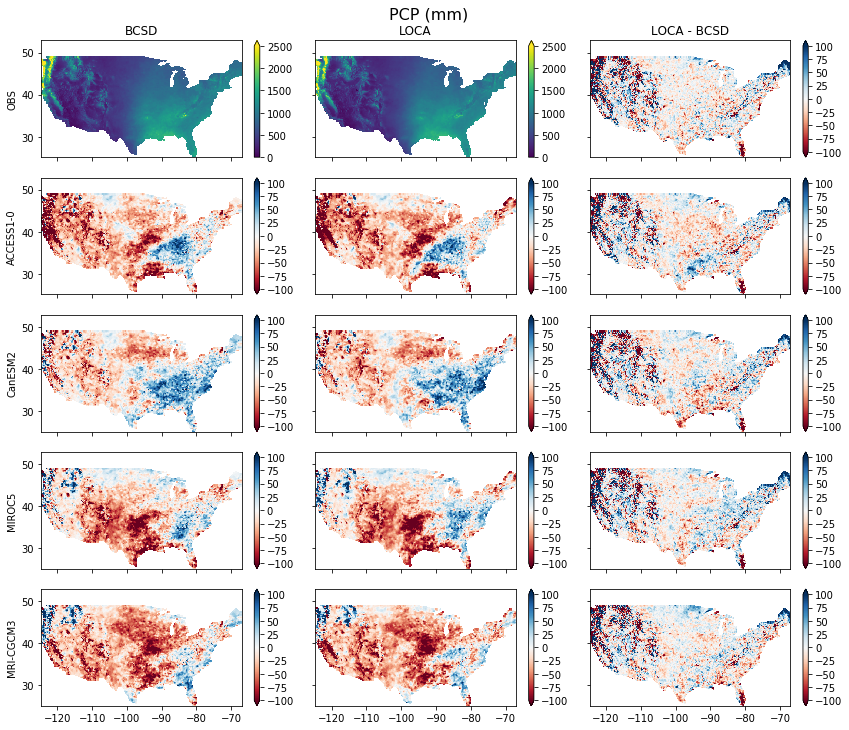

In [24]:

units = {'pcp': 'mm', 't_mean': 'C'}

nrows = 1 + len(models)
ncols = 2


diff_kws = {False: {'pcp': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu'}, 't_mean': {'vmin': -1, 'vmax': 1, 'cmap': 'RdBu_r'}},
            True: {'pcp': {'vmin': -25, 'vmax': 25, 'cmap': 'RdBu'}}}


for var in met_vars:
    
    #for pct in [True, False]:
    for pct in [False]:
        
        if var not in diff_kws[pct]:
            continue
    
        fig, axes = plt.subplots(ncols=ncols + 1, nrows=nrows, sharex=True, sharey=True, figsize=(12, 2*nrows))

        for col, (title, obs_data, ds_data) in enumerate([('BCSD', epoch_means['maurer'], epoch_means['bcsd']),
                                                          ('LOCA', epoch_means['livneh'], epoch_means['loca'])]):

            ax = axes[0, col]
            obs_data[var].plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])

            if col == 0:
                ax.set_ylabel('OBS')

            ax.set_title(title)
    
            diff = calc_change(obs_data[var], ds_data[var], pct=pct).persist()
            for row, model in enumerate(models, 1):
                ax = axes[row, col]
                diff.sel(gcm=model).plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[pct][var])

                if col == 0:
                    ax.set_ylabel(model)

        ax = axes[0, -1]
        calc_change(epoch_means['maurer'][var], epoch_means['livneh'][var], pct=pct).plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[pct][var])
        ax.set_title('LOCA - BCSD')  

        diff = calc_change(epoch_means['bcsd'][var], epoch_means['loca'][var], pct=pct).persist()
        for row, model in enumerate(models, 1):
            ax = axes[row, -1]  
            diff.sel(gcm=model).plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[pct][var])

            
        title = var.upper()
        title += ' (%s)' % units[var]
        if pct:
            title += ' (%)'
            unit_str = 'pct'
        else:
            unit_str = units[var]
        fig.suptitle(title, fontsize=16, y=1.01)
        fig.tight_layout()  
        fig.savefig(f'/glade/u/home/jvano/workdir/loca_figs/diff_{var}_{unit_str}_monthly_historic_met.png', dpi=300, bbox_inches='tight')
        #fig.savefig(f'/glade/u/home/jvano/workdir/loca_figs/diff_{var}_{unit_str}_monthly_historic_met_80s-90s.png', dpi=300, bbox_inches='tight')

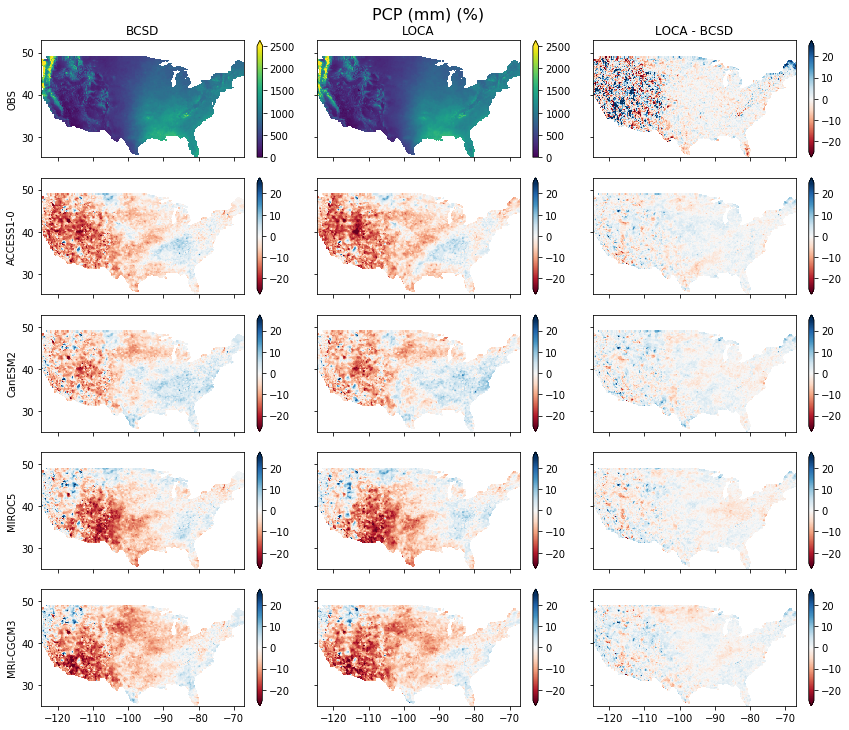

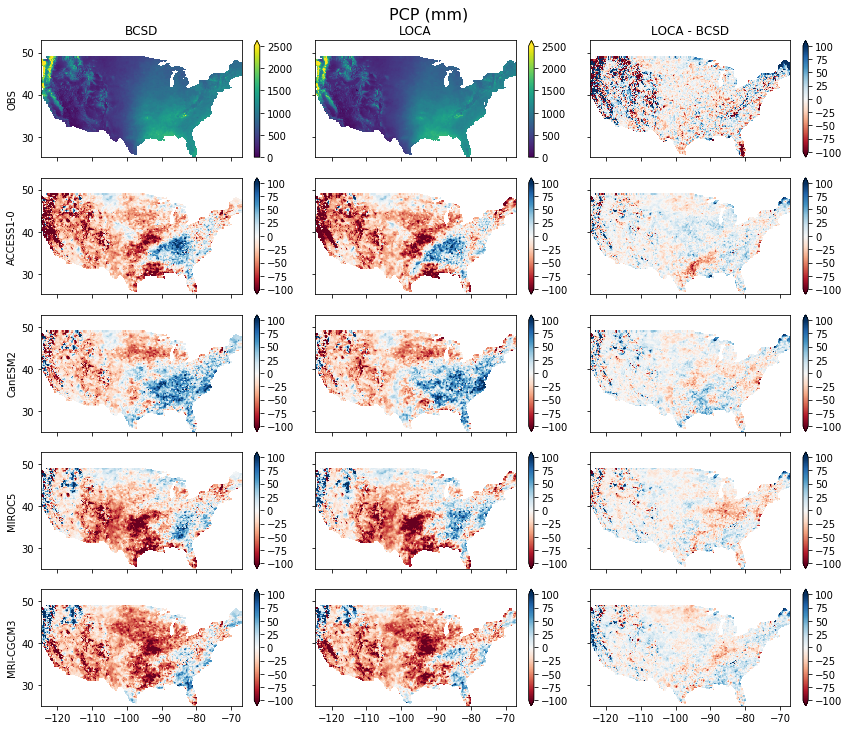

In [25]:
cache = {}

for var in met_vars:
    
    for pct in [True, False]:
        
        if var not in diff_kws[pct]:
            continue
    
        fig, axes = plt.subplots(ncols=ncols + 1, nrows=nrows, sharex=True, sharey=True, figsize=(12, 2*nrows))

        for col, (title, obs_data, ds_data) in enumerate([('BCSD', epoch_means['maurer'], epoch_means['bcsd']),
                                                          ('LOCA', epoch_means['livneh'], epoch_means['loca'])]):

            ax = axes[0, col]
            obs_data[var].plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])

            if col == 0:
                ax.set_ylabel('OBS')

            ax.set_title(title)
    
            diff = calc_change(obs_data[var], ds_data[var], pct=pct).persist()
            for row, model in enumerate(models, 1):
                ax = axes[row, col]
                diff.sel(gcm=model).plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[pct][var])
                cache[(row, col)] = diff.sel(gcm=model)
                if col == 0:
                    ax.set_ylabel(model)

        ax = axes[0, -1]
        calc_change(epoch_means['maurer'][var], epoch_means['livneh'][var], pct=pct).plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[pct][var])
        ax.set_title('LOCA - BCSD')

        for row, model in enumerate(models, 1):
            ax = axes[row, -1]
            diff = cache[(row, 0)] - cache[(row, 1)] #DIFF OF A DIFF JAV, right?
            diff.plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[pct][var])

            
        title = var.upper()
        title += ' (%s)' % units[var]
        if pct:
            title += ' (%)'
            unit_str = 'pct'
        else:
            unit_str = units[var]
        fig.suptitle(title, fontsize=16, y=1.01)
        fig.tight_layout()  
        fig.savefig(f'/glade/u/home/jvano/workdir/loca_figs/diff2_{var}_{unit_str}_monthly_historic_met.png', dpi=300, bbox_inches='tight')

In [ ]:
# cleanup 
plt.close('all')